In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
import seaborn as sns

# for CVXPY implementation
from solardatatools.signal_decompositions import l2_l1d1_l2d2p365 as cvx_sd
from solardatatools.algorithms import TimeShift

# for OSD implementation
import cvxpy as cvx
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from solardatatools.solar_noon import energy_com, avg_sunrise_sunset
from solardatatools.osd_signal_decompositions import l2_l1d1_l2d2p365 as osd_sd

In [2]:
# Import data
fixtures_path = "/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/"

input_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_with_shift.csv")
with open(input_power_signals_file_path) as file:
    power_data_matrix = np.loadtxt(file, delimiter=",")

use_days_file_path = Path(fixtures_path + "time_shifts/clear_days.csv")
with open(use_days_file_path) as file:
    use_days = np.loadtxt(file, delimiter=",")

output_power_signals_file_path = Path(fixtures_path + "time_shifts/two_year_signal_fixed.csv")
with open(output_power_signals_file_path) as file:
    expected_power_data_fix = np.loadtxt(file, delimiter=",")

In [3]:
# ##### CVXPY
# cvx_time_shift_analysis = TimeShift()
# cvx_time_shift_analysis.run(power_data_matrix, use_ixs=use_days, solver="MOSEK")
# cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data

# np.testing.assert_almost_equal(cvx_actual_power_data_fix, expected_power_data_fix, decimal=0.2)

In [4]:
### Define OSD class/function (reference right fn and update arg names, keeping c1 vals the same)

class TimeShiftOSDSimple:
    def __init__(self):
        self.metric = None
        self.s1 = None
        self.s2 = None
        self.index_set = None
        self.corrected_data = None
        self.roll_by_index = None
        self.normalized_holdout_error = None
        self.normalized_train_error = None
        self.tv_metric = None
        self.jumps_per_year = None
        self.best_c1 = None
        self.best_ix = None
        self.__recursion_depth = 0

    def run(
        self,
        data,
        use_ixs=None,
        c1=None,
        c2=200.0,
        solar_noon_estimator="com",
        threshold=0.1,
        periodic_detector=False,
        solver=None,
    ):
        if solar_noon_estimator == "com":
            metric = energy_com(data)
        elif solar_noon_estimator == "srss":
            metric = avg_sunrise_sunset(data, threshold=threshold)
        self.metric = metric
        if use_ixs is None:
            use_ixs = ~np.isnan(metric)
        else:
            use_ixs = np.logical_and(use_ixs, ~np.isnan(metric))
        self.use_ixs = use_ixs
        # Optimize c1
        if c1 is None: # unused
            c1s = np.logspace(-1, 2, 11)
            #c1s = np.logspace(0.55, 2, 11)
            hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                metric, c1s, use_ixs, c2, periodic_detector, solver=solver
            )
            if tv_metric[best_ix] >= 0.009:
                # rerun the optimizer with a new random data selection
                hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                    metric, c1s, use_ixs, c2, periodic_detector, solver=solver
                )
            # if np.isclose(hn[best_ix], hn[-1]):
            #     best_ix = np.argmax(hn * rn)
            best_c1 = c1s[best_ix]
        else:
            best_c1 = c1
            hn = None
            rn = None
            tv_metric = None
            jpy = None
            c1s = None
            best_ix = None
        s1, s2 = self.estimate_components(
            metric, best_c1, c2, use_ixs, periodic_detector, solver=solver
        )
        # find indices of transition points
        index_set = np.arange(len(s1) - 1)[np.round(np.diff(s1, n=1), 3) != 0]
        # print(len(index_set), len(index_set) / (len(metric) / 365))
        s1, s2 = self.estimate_components(
            metric,
            best_c1,
            c2,
            use_ixs,
            periodic_detector,
            transition_locs=index_set,
            solver=solver,
        )
        jumps_per_year = len(index_set) / (len(metric) / 365)
        cond1 = jumps_per_year >= 5
        cond2 = c1 is None
        cond3 = self.__recursion_depth < 2
        if cond1 and cond2 and cond3:
            # Unlikely that  there are more than 5 time shifts per year. Try a
            # different random sampling
            self.__recursion_depth += 1
            self.run(
                data,
                use_ixs=use_ixs,
                c1=c1,
                c2=c2,
                solar_noon_estimator=solar_noon_estimator,
                threshold=threshold,
                periodic_detector=periodic_detector,
                solver=solver,
            )
            return
        # Apply corrections
        roll_by_index = np.round(
            (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
        )
        correction_metric = np.average(np.abs(roll_by_index))
        if correction_metric < 0.01:
            roll_by_index[:] = 0
        self.roll_by_index = roll_by_index
        index_set = np.arange(len(roll_by_index) - 1)[
            np.round(np.diff(roll_by_index, n=1), 3) != 0
        ]
        Dout = self.apply_corrections(data)

        # save results
        self.normalized_holdout_error = hn
        self.normalized_train_error = rn
        self.tv_metric = tv_metric
        self.jumps_per_year = jpy
        self.c1_vals = c1s
        self.best_c1 = best_c1
        self.best_ix = best_ix
        self.s1 = s1
        self.s2 = s2
        self.index_set = index_set
        self.corrected_data = Dout
        self.__recursion_depth = 0

    def optimize_c1(self, metric, c1s, use_ixs, c2, periodic_detector, solver=None):
        # set up train/test split with sklearn
        ixs = np.arange(len(metric))
        ixs = ixs[use_ixs]
        train_ixs, test_ixs = train_test_split(ixs, test_size=0.85)
        train = np.zeros(len(metric), dtype=bool)
        test = np.zeros(len(metric), dtype=bool)
        train[train_ixs] = True
        test[test_ixs] = True
        # initialize results objects
        train_r = np.zeros_like(c1s)
        test_r = np.zeros_like(c1s)
        tv_metric = np.zeros_like(c1s)
        jpy = np.zeros_like(c1s)
        # iterate over possible values of c1 parameter
        for i, v in enumerate(c1s):
            s1, s2 = self.estimate_components(
                metric, v, c2, train, periodic_detector, n_iter=5, solver=solver
            )
            y = metric
            # collect results
            train_r[i] = np.average(np.power((y - s1 - s2)[train], 2))
            test_r[i] = np.average(np.power((y - s1 - s2)[test], 2))
            tv_metric[i] = np.average(np.abs(np.diff(s1, n=1)))
            count_jumps = np.sum(~np.isclose(np.diff(s1), 0, atol=1e-4))
            jumps_per_year = count_jumps / (len(metric) / 365)
            jpy[i] = jumps_per_year

        def zero_one_scale(x):
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        hn = zero_one_scale(test_r)  # holdout error metrix
        rn = zero_one_scale(train_r)
        ixs = np.arange(len(c1s))
        # Detecting more than 5 time shifts per year is extremely uncommon,
        # and is considered non-physical
        slct = np.logical_and(jpy <= 5, hn <= 0.02)
        # slct = np.logical_and(slct, rn < 0.9)
        best_ix = np.nanmax(ixs[slct])
        return hn, rn, tv_metric, jpy, best_ix

    def estimate_components(
        self,
        metric,
        c1,
        c2,
        use_ixs,
        periodic_detector,
        transition_locs=None,
        n_iter=5,
        solver=None,
    ):
        # Iterative reweighted L1 heuristic
        w = np.ones(len(metric) - 1)
        eps = 0.1
        #for i in range(n_iter): # set this to 1
            #################################################################################
        s1, s2 = osd_sd(
            metric,
            w1=c1,
            w2=c2,
            #tv_weights=w, # do not use this to compare first pass
            use_ixs=use_ixs,
            yearly_periodic=periodic_detector,
            transition_locs=transition_locs,
            #seas_max=None,
            solver=solver,
        )
            #################################################################################
            #w = 1 / (eps + np.abs(np.diff(s1, n=1)))
        return s1, s2

    def plot_analysis(self, figsize=None):
        if self.metric is not None:
            import matplotlib.pyplot as plt

            fig = plt.figure(figsize=figsize)
            plt.plot(self.metric, linewidth=1, label="metric")
            plt.plot(self.s1, label="shift detector")
            plt.plot(self.s1 + self.s2, ls="--", label="SD model")
            plt.legend()
            plt.xlabel("day number")
            plt.ylabel("solar noon [hours]")
            return fig

    def plot_optimization(self, figsize=None):
        if self.best_ix is not None:
            c1s = self.c1_vals
            hn = self.normalized_holdout_error
            rn = self.normalized_train_error
            best_c1 = self.best_c1
            import matplotlib.pyplot as plt

            fig, ax = plt.subplots(nrows=4, sharex=True, figsize=figsize)
            ax[0].plot(c1s, hn, marker=".")
            ax[0].axvline(best_c1, ls="--", color="red")
            ax[0].set_title("holdout validation")
            ax[1].plot(c1s, self.jumps_per_year, marker=".")
            ax[1].axvline(best_c1, ls="--", color="red")
            ax[1].set_title("jumps per year")
            ax[2].plot(c1s, rn, marker=".")
            ax[2].axvline(best_c1, ls="--", color="red")
            ax[2].set_title("training residuals")
            ax[3].plot(c1s, self.tv_metric, marker=".")
            ax[3].axvline(best_c1, ls="--", color="red")
            ax[3].set_xscale("log")
            ax[3].set_title("Total variation metric")
            plt.tight_layout()
            return fig

    def apply_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, int(roll), axis=0)[:, ixs]
        return Dout

    def invert_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, -int(roll), axis=0)[:, ixs]
        return Dout

In [5]:
class TimeShiftCVXSimple:
    def __init__(self):
        self.metric = None
        self.s1 = None
        self.s2 = None
        self.index_set = None
        self.corrected_data = None
        self.roll_by_index = None
        self.normalized_holdout_error = None
        self.normalized_train_error = None
        self.tv_metric = None
        self.jumps_per_year = None
        self.best_c1 = None
        self.best_ix = None
        self.__recursion_depth = 0

    def run(
        self,
        data,
        use_ixs=None,
        c1=None,
        c2=200.0,
        solar_noon_estimator="com",
        threshold=0.1,
        periodic_detector=False,
        solver=None,
    ):
        if solar_noon_estimator == "com":
            metric = energy_com(data)
        elif solar_noon_estimator == "srss":
            metric = avg_sunrise_sunset(data, threshold=threshold)
        self.metric = metric
        if use_ixs is None:
            use_ixs = ~np.isnan(metric)
        else:
            use_ixs = np.logical_and(use_ixs, ~np.isnan(metric))
        self.use_ixs = use_ixs
        # Optimize c1
        if c1 is None:
            pass
            # c1s = np.logspace(-1, 2, 11)
            # hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
            #     metric, c1s, use_ixs, c2, periodic_detector, solver=solver
            # )
            # if tv_metric[best_ix] >= 0.009:
            #     # rerun the optimizer with a new random data selection
            #     hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
            #         metric, c1s, use_ixs, c2, periodic_detector, solver=solver
            #     )
            # # if np.isclose(hn[best_ix], hn[-1]):
            # #     best_ix = np.argmax(hn * rn)
            # best_c1 = c1s[best_ix]
        else:
            best_c1 = c1
            hn = None
            rn = None
            tv_metric = None
            jpy = None
            c1s = None
            best_ix = None
        s1, s2 = self.estimate_components(
            metric, best_c1, c2, use_ixs, periodic_detector, solver=solver
        )
        # find indices of transition points
        index_set = np.arange(len(s1) - 1)[np.round(np.diff(s1, n=1), 3) != 0]
        # print(len(index_set), len(index_set) / (len(metric) / 365))
        s1, s2 = self.estimate_components(
            metric,
            best_c1,
            c2,
            use_ixs,
            periodic_detector,
            transition_locs=index_set,
            solver=solver,
        )
        jumps_per_year = len(index_set) / (len(metric) / 365)
        cond1 = jumps_per_year >= 5
        cond2 = c1 is None
        cond3 = self.__recursion_depth < 2
        if cond1 and cond2 and cond3:
            # Unlikely that  there are more than 5 time shifts per year. Try a
            # different random sampling
            self.__recursion_depth += 1
            self.run(
                data,
                use_ixs=use_ixs,
                c1=c1,
                c2=c2,
                solar_noon_estimator=solar_noon_estimator,
                threshold=threshold,
                periodic_detector=periodic_detector,
                solver=solver,
            )
            return
        # Apply corrections
        roll_by_index = np.round(
            (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
        )
        correction_metric = np.average(np.abs(roll_by_index))
        if correction_metric < 0.01:
            roll_by_index[:] = 0
        self.roll_by_index = roll_by_index
        index_set = np.arange(len(roll_by_index) - 1)[
            np.round(np.diff(roll_by_index, n=1), 3) != 0
        ]
        Dout = self.apply_corrections(data)

        # save results
        self.normalized_holdout_error = hn
        self.normalized_train_error = rn
        self.tv_metric = tv_metric
        self.jumps_per_year = jpy
        self.c1_vals = c1s
        self.best_c1 = best_c1
        self.best_ix = best_ix
        self.s1 = s1
        self.s2 = s2
        self.index_set = index_set
        self.corrected_data = Dout
        self.__recursion_depth = 0

#     def optimize_c1(self, metric, c1s, use_ixs, c2, periodic_detector, solver=None):
#         # set up train/test split with sklearn
#         ixs = np.arange(len(metric))
#         ixs = ixs[use_ixs]
#         train_ixs, test_ixs = train_test_split(ixs, test_size=0.85)
#         train = np.zeros(len(metric), dtype=bool)
#         test = np.zeros(len(metric), dtype=bool)
#         train[train_ixs] = True
#         test[test_ixs] = True
#         # initialize results objects
#         train_r = np.zeros_like(c1s)
#         test_r = np.zeros_like(c1s)
#         tv_metric = np.zeros_like(c1s)
#         jpy = np.zeros_like(c1s)
#         # iterate over possible values of c1 parameter
#         for i, v in enumerate(c1s):
#             s1, s2 = self.estimate_components(
#                 metric, v, c2, train, periodic_detector, n_iter=5, solver=solver
#             )
#             y = metric
#             # collect results
#             train_r[i] = np.average(np.power((y - s1 - s2)[train], 2))
#             test_r[i] = np.average(np.power((y - s1 - s2)[test], 2))
#             tv_metric[i] = np.average(np.abs(np.diff(s1, n=1)))
#             count_jumps = np.sum(~np.isclose(np.diff(s1), 0, atol=1e-4))
#             jumps_per_year = count_jumps / (len(metric) / 365)
#             jpy[i] = jumps_per_year

#         def zero_one_scale(x):
#             return (x - np.min(x)) / (np.max(x) - np.min(x))

#         hn = zero_one_scale(test_r)  # holdout error metrix
#         rn = zero_one_scale(train_r)
#         ixs = np.arange(len(c1s))
#         # Detecting more than 5 time shifts per year is extremely uncommon,
#         # and is considered non-physical
#         slct = np.logical_and(jpy <= 5, hn <= 0.02)
#         # slct = np.logical_and(slct, rn < 0.9)
#         best_ix = 0 # np.nanmax(ixs[slct])
#         return hn, rn, tv_metric, jpy, best_ix

    def estimate_components(
        self,
        metric,
        c1,
        c2,
        use_ixs,
        periodic_detector,
        transition_locs=None,
        n_iter=5,
        solver=None,
    ):
        # Iterative reweighted L1 heuristic
        w = np.ones(len(metric) - 1)
        eps = 0.1
        #for i in range(n_iter): # set this to 1
            #################################################################################
        s1, s2 = cvx_sd(
            metric,
            c1=c1,
            c2=c2,
            tv_weights=w, # do not use this to compare first pass
            use_ixs=use_ixs,
            yearly_periodic=periodic_detector,
            transition_locs=transition_locs,
            #seas_max=None,
            solver=solver,
        )
            #################################################################################
            #w = 1 / (eps + np.abs(np.diff(s1, n=1)))
        return s1, s2

    def plot_analysis(self, figsize=None):
        if self.metric is not None:
            import matplotlib.pyplot as plt

            fig = plt.figure(figsize=figsize)
            plt.plot(self.metric, linewidth=1, label="metric")
            plt.plot(self.s1, label="shift detector")
            plt.plot(self.s1 + self.s2, ls="--", label="SD model")
            plt.legend()
            plt.xlabel("day number")
            plt.ylabel("solar noon [hours]")
            return fig

    def plot_optimization(self, figsize=None):
        if self.best_ix is not None:
            c1s = self.c1_vals
            hn = self.normalized_holdout_error
            rn = self.normalized_train_error
            best_c1 = self.best_c1
            import matplotlib.pyplot as plt

            fig, ax = plt.subplots(nrows=4, sharex=True, figsize=figsize)
            ax[0].plot(c1s, hn, marker=".")
            ax[0].axvline(best_c1, ls="--", color="red")
            ax[0].set_title("holdout validation")
            ax[1].plot(c1s, self.jumps_per_year, marker=".")
            ax[1].axvline(best_c1, ls="--", color="red")
            ax[1].set_title("jumps per year")
            ax[2].plot(c1s, rn, marker=".")
            ax[2].axvline(best_c1, ls="--", color="red")
            ax[2].set_title("training residuals")
            ax[3].plot(c1s, self.tv_metric, marker=".")
            ax[3].axvline(best_c1, ls="--", color="red")
            ax[3].set_xscale("log")
            ax[3].set_title("Total variation metric")
            plt.tight_layout()
            return fig

    def apply_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, int(roll), axis=0)[:, ixs]
        return Dout

    def invert_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, -int(roll), axis=0)[:, ixs]
        return Dout

### Simple example with no c1 opimization or iterative reweighting 

/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/3733886136.py:99: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/2055476693.py:97: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

s1 MAE (OSD,CVX)   1.22e-01
s2 MAE (OSD,CVX)   9.54e-02


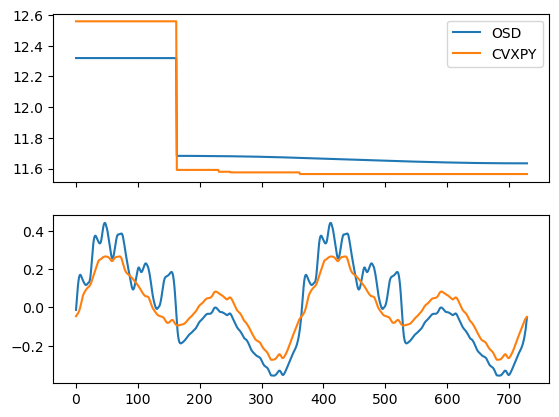

In [6]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSDSimple()
qosd_time_shift_analysis.run(power_data_matrix, c1=100, c2=200, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1
qosd_s2 = qosd_time_shift_analysis.s2

##### CVX
cvx_time_shift_analysis = TimeShiftCVXSimple()
cvx_time_shift_analysis.run(power_data_matrix, c1=100, c2=200, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1
cvx_s2 = cvx_time_shift_analysis.s2


print(f's1 MAE (OSD,CVX)   {mae(qosd_s1, cvx_s1):.2e}')
print(f's2 MAE (OSD,CVX)   {mae(qosd_s2, cvx_s2):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(qosd_s1, label="OSD")
ax1.plot(cvx_s1, label="CVXPY")
ax2.plot(qosd_s2)
ax2.plot(cvx_s2)
ax1.legend()
plt.show()

/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/3733886136.py:99: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/2055476693.py:97: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

s1 MAE (OSD,CVX)   5.30e-03
s2 MAE (OSD,CVX)   3.47e-03


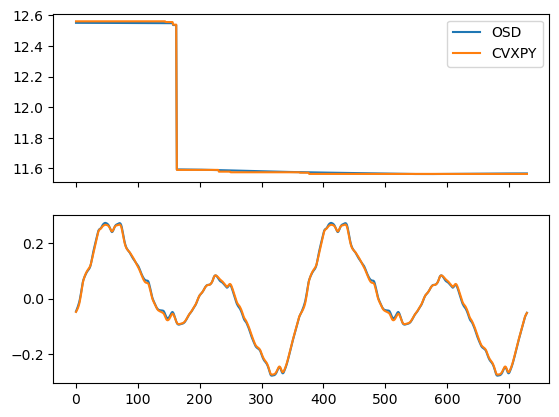

In [7]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSDSimple()
qosd_time_shift_analysis.run(power_data_matrix, c1=5, c2=200, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1
qosd_s2 = qosd_time_shift_analysis.s2

##### CVX
cvx_time_shift_analysis = TimeShiftCVXSimple()
cvx_time_shift_analysis.run(power_data_matrix, c1=5, c2=200, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1
cvx_s2 = cvx_time_shift_analysis.s2


print(f's1 MAE (OSD,CVX)   {mae(qosd_s1, cvx_s1):.2e}')
print(f's2 MAE (OSD,CVX)   {mae(qosd_s2, cvx_s2):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(qosd_s1, label="OSD")
ax1.plot(cvx_s1, label="CVXPY")
ax2.plot(qosd_s2)
ax2.plot(cvx_s2)
ax1.legend()
plt.show()

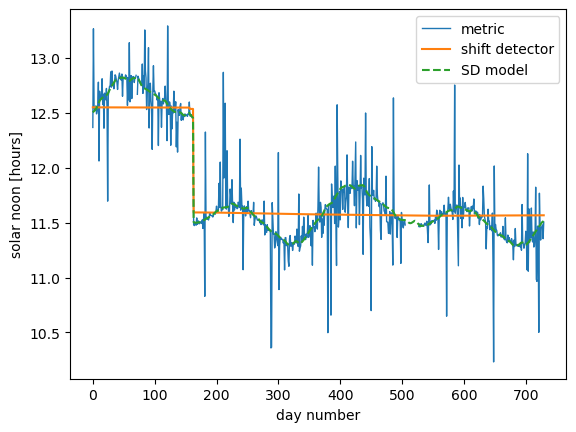

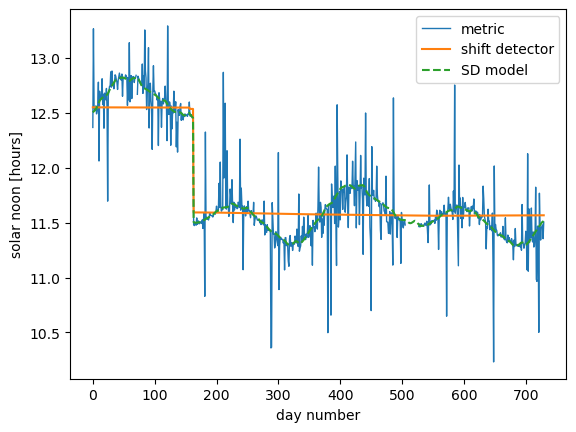

In [8]:
qosd_time_shift_analysis.plot_analysis()

/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/3733886136.py:99: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/2055476693.py:97: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

s1 MAE (OSD,CVX)   5.37e-03
s2 MAE (OSD,CVX)   3.58e-03


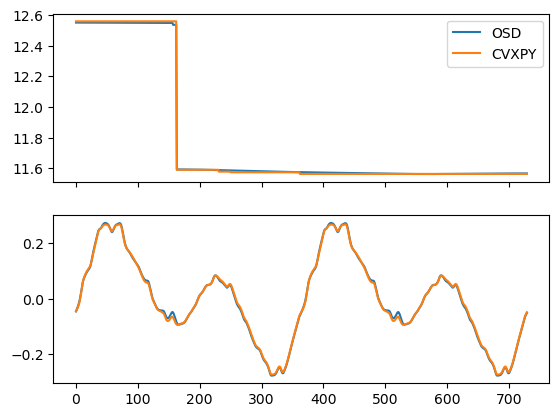

In [8]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSDSimple()
qosd_time_shift_analysis.run(power_data_matrix, c1=5, c2=200, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1
qosd_s2 = qosd_time_shift_analysis.s2

##### CVX
cvx_time_shift_analysis = TimeShiftCVXSimple()
cvx_time_shift_analysis.run(power_data_matrix, c1=100, c2=200, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1
cvx_s2 = cvx_time_shift_analysis.s2


print(f's1 MAE (OSD,CVX)   {mae(qosd_s1, cvx_s1):.2e}')
print(f's2 MAE (OSD,CVX)   {mae(qosd_s2, cvx_s2):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(qosd_s1, label="OSD")
ax1.plot(cvx_s1, label="CVXPY")
ax2.plot(qosd_s2)
ax2.plot(cvx_s2)
ax1.legend()
plt.show()

### With c1 optimization

In [33]:
class TimeShiftOSD:
    def __init__(self):
        self.atol = 1e-4
        self.sum_card_bool=False
        self.plot_jumps=False
        
        
        self.metric = None
        self.s1 = None
        self.s2 = None
        self.index_set = None
        self.corrected_data = None
        self.roll_by_index = None
        self.normalized_holdout_error = None
        self.normalized_train_error = None
        self.tv_metric = None
        self.jumps_per_year = None
        self.best_c1 = None
        self.best_ix = None
        self.__recursion_depth = 0

    def run(
        self,
        data,
        use_ixs=None,
        c1=None,
        c2=200.0,
        solar_noon_estimator="com",
        threshold=0.1,
        periodic_detector=False,
        solver=None,
    ):
        if solar_noon_estimator == "com":
            metric = energy_com(data)
        elif solar_noon_estimator == "srss":
            metric = avg_sunrise_sunset(data, threshold=threshold)
        self.metric = metric
        if use_ixs is None:
            use_ixs = ~np.isnan(metric)
        else:
            use_ixs = np.logical_and(use_ixs, ~np.isnan(metric))
        self.use_ixs = use_ixs
        # Optimize c1
        if c1 is None:
            c1s = np.logspace(-1, 2, 11)
            #c1s = np.logspace(0.3, 2, 15)
            #c1s = [2, 5, 10, 15, 50, 100]
            hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                metric, c1s, use_ixs, c2, periodic_detector, solver=solver
            )
            if tv_metric[best_ix] >= 0.009:
                # rerun the optimizer with a new random data selection
                hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                    metric, c1s, use_ixs, c2, periodic_detector, solver=solver
                )
            # if np.isclose(hn[best_ix], hn[-1]):
            #     best_ix = np.argmax(hn * rn)
            best_c1 = c1s[best_ix]
        else:
            best_c1 = c1
            hn = None
            rn = None
            tv_metric = None
            jpy = None
            c1s = None
            best_ix = None
        s1, s2 = self.estimate_components(
            metric, best_c1, c2, use_ixs, periodic_detector, solver=solver
        )
        # find indices of transition points
        index_set = np.arange(len(s1) - 1)[np.round(np.diff(s1, n=1), 3) != 0]
        # print(len(index_set), len(index_set) / (len(metric) / 365))
        #print("c1 ", best_c1)
        s1, s2 = self.estimate_components(
            metric,
            best_c1,
            c2,
            use_ixs,
            periodic_detector,
            transition_locs=index_set,
            solver=solver,
        )
        jumps_per_year = len(index_set) / (len(metric) / 365)
        cond1 = jumps_per_year >= 5
        cond2 = c1 is None
        cond3 = self.__recursion_depth < 2
        if cond1 and cond2 and cond3:
            # Unlikely that  there are more than 5 time shifts per year. Try a
            # different random sampling
            self.__recursion_depth += 1
            self.run(
                data,
                use_ixs=use_ixs,
                c1=c1,
                c2=c2,
                solar_noon_estimator=solar_noon_estimator,
                threshold=threshold,
                periodic_detector=periodic_detector,
                solver=solver,
            )
            return
        # Apply corrections
        roll_by_index = np.round(
            (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
        )
        correction_metric = np.average(np.abs(roll_by_index))
        if correction_metric < 0.01:
            roll_by_index[:] = 0
        self.roll_by_index = roll_by_index
        index_set = np.arange(len(roll_by_index) - 1)[
            np.round(np.diff(roll_by_index, n=1), 3) != 0
        ]
        Dout = self.apply_corrections(data)

        # save results
        self.normalized_holdout_error = hn
        self.normalized_train_error = rn
        self.tv_metric = tv_metric
        self.jumps_per_year = jpy
        self.c1_vals = c1s
        self.best_c1 = best_c1
        self.best_ix = best_ix
        self.s1 = s1
        self.s2 = s2
        self.index_set = index_set
        self.corrected_data = Dout
        self.__recursion_depth = 0

    def optimize_c1(self, metric, c1s, use_ixs, c2, periodic_detector, solver=None):
        # set up train/test split with sklearn
        ixs = np.arange(len(metric))
        ixs = ixs[use_ixs]
        train_ixs, test_ixs = train_test_split(ixs, test_size=0.85)
        train = np.zeros(len(metric), dtype=bool)
        test = np.zeros(len(metric), dtype=bool)
        train[train_ixs] = True
        test[test_ixs] = True
        # initialize results objects
        train_r = np.zeros_like(c1s)
        test_r = np.zeros_like(c1s)
        tv_metric = np.zeros_like(c1s)
        jpy = np.zeros_like(c1s)
        # iterate over possible values of c1 parameter
        for i, v in enumerate(c1s):
            s1, s2 = self.estimate_components(
                metric, v, c2, train, periodic_detector, n_iter=5, solver=solver
            )
            y = metric
            # collect results
            train_r[i] = np.average(np.power((y - s1 - s2)[train], 2))
            test_r[i] = np.average(np.power((y - s1 - s2)[test], 2))
            tv_metric[i] = np.average(np.abs(np.diff(s1, n=1)))
            count_jumps = np.sum(~np.isclose(np.diff(s1), 0, atol=self.atol))
            #######################
            if self.plot_jumps:
                print("count_jumps ", count_jumps)
                idxs = ~np.isclose(np.diff(s1), 0, atol=self.atol)
                fig = plt.figure(figsize=(4,3))
                plt.plot(s1)
                plt.plot(np.arange(1,730,1)[idxs], s1[1:][idxs], marker=".", linewidth=0)
                plt.show()
            ##############
            jumps_per_year = count_jumps / (len(metric) / 365)
            jpy[i] = jumps_per_year

        def zero_one_scale(x):
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        hn = zero_one_scale(test_r)  # holdout error metrix
        rn = zero_one_scale(train_r)
        ixs = np.arange(len(c1s))
        
        # Detecting more than 5 time shifts per year is extremely uncommon,
        # and is considered non-physical
        slct = np.logical_and(jpy <= 5, hn <= 0.02)
        # slct = np.logical_and(slct, rn < 0.9)
        best_ix = np.nanmax(ixs[slct])
        print("OSD c1s ", c1s)
        print("OSD best c1 ", c1s[best_ix])
        return hn, rn, tv_metric, jpy, best_ix

    def estimate_components(
        self,
        metric,
        c1,
        c2,
        use_ixs,
        periodic_detector,
        transition_locs=None,
        n_iter=5,
        solver=None,
    ):
        # Iterative reweighted L1 heuristic
        w = np.ones(len(metric) - 1)
        eps = 0.1
        for i in range(n_iter): # set this to 1
            #################################################################################
            s1, s2 = osd_sd(
                metric,
                w1=c1,
                w2=c2,
                #tv_weights=w, # do not use this to compare first pass
                use_ixs=use_ixs,
                yearly_periodic=periodic_detector,
                transition_locs=transition_locs,
                #seas_max=None,
                solver=solver,
                sum_card=self.sum_card_bool
            )
            #################################################################################
            #w = 1 / (eps + np.abs(np.diff(s1, n=1)))
        return s1, s2

    def plot_analysis(self, figsize=None):
        if self.metric is not None:
            import matplotlib.pyplot as plt

            fig = plt.figure(figsize=figsize)
            plt.plot(self.metric, linewidth=1, label="metric")
            plt.plot(self.s1, label="shift detector")
            plt.plot(self.s1 + self.s2, ls="--", label="SD model")
            plt.legend()
            plt.xlabel("day number")
            plt.ylabel("solar noon [hours]")
            return fig

    def plot_optimization(self, figsize=None):
        if self.best_ix is not None:
            c1s = self.c1_vals
            hn = self.normalized_holdout_error
            rn = self.normalized_train_error
            best_c1 = self.best_c1
            import matplotlib.pyplot as plt

            fig, ax = plt.subplots(nrows=4, sharex=True, figsize=figsize)
            ax[0].plot(c1s, hn, marker=".")
            ax[0].axvline(best_c1, ls="--", color="red")
            ax[0].set_title("holdout validation")
            ax[1].plot(c1s, self.jumps_per_year, marker=".")
            ax[1].axvline(best_c1, ls="--", color="red")
            ax[1].set_title("jumps per year")
            ax[2].plot(c1s, rn, marker=".")
            ax[2].axvline(best_c1, ls="--", color="red")
            ax[2].set_title("training residuals")
            ax[3].plot(c1s, self.tv_metric, marker=".")
            ax[3].axvline(best_c1, ls="--", color="red")
            ax[3].set_xscale("log")
            ax[3].set_title("Total variation metric")
            plt.tight_layout()
            plt.show()
            return fig

    def apply_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, int(roll), axis=0)[:, ixs]
        return Dout

    def invert_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, -int(roll), axis=0)[:, ixs]
        return Dout

In [25]:
class TimeShiftCVX:
    def __init__(self):
        self.atol = 1e-4
        self.iterative_reweight=False
            
            
        self.metric = None
        self.s1 = None
        self.s2 = None
        self.index_set = None
        self.corrected_data = None
        self.roll_by_index = None
        self.normalized_holdout_error = None
        self.normalized_train_error = None
        self.tv_metric = None
        self.jumps_per_year = None
        self.best_c1 = None
        self.best_ix = None
        self.__recursion_depth = 0

    def run(
        self,
        data,
        use_ixs=None,
        c1=None,
        c2=200.0,
        solar_noon_estimator="com",
        threshold=0.1,
        periodic_detector=False,
        solver=None,
    ):
        if solar_noon_estimator == "com":
            metric = energy_com(data)
        elif solar_noon_estimator == "srss":
            metric = avg_sunrise_sunset(data, threshold=threshold)
        self.metric = metric
        if use_ixs is None:
            use_ixs = ~np.isnan(metric)
        else:
            use_ixs = np.logical_and(use_ixs, ~np.isnan(metric))
        self.use_ixs = use_ixs
        # Optimize c1
        if c1 is None:
            c1s = np.logspace(-1, 2, 11)
            hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                metric, c1s, use_ixs, c2, periodic_detector, solver=solver
            )
            if tv_metric[best_ix] >= 0.009:
                # rerun the optimizer with a new random data selection
                hn, rn, tv_metric, jpy, best_ix = self.optimize_c1(
                    metric, c1s, use_ixs, c2, periodic_detector, solver=solver
                )
            # if np.isclose(hn[best_ix], hn[-1]):
            #     best_ix = np.argmax(hn * rn)
            best_c1 = c1s[best_ix]
        else:
            best_c1 = c1
            hn = None
            rn = None
            tv_metric = None
            jpy = None
            c1s = None
            best_ix = None
        s1, s2 = self.estimate_components(
            metric, best_c1, c2, use_ixs, periodic_detector, solver=solver
        )
        # find indices of transition points
        index_set = np.arange(len(s1) - 1)[np.round(np.diff(s1, n=1), 3) != 0]
        # print(len(index_set), len(index_set) / (len(metric) / 365))
        print("c1 ", best_c1)
        s1, s2 = self.estimate_components(
            metric,
            best_c1,
            c2,
            use_ixs,
            periodic_detector,
            transition_locs=index_set,
            solver=solver,
        )
        jumps_per_year = len(index_set) / (len(metric) / 365)
        cond1 = jumps_per_year >= 5
        cond2 = c1 is None
        cond3 = self.__recursion_depth < 2
        if cond1 and cond2 and cond3:
            # Unlikely that  there are more than 5 time shifts per year. Try a
            # different random sampling
            self.__recursion_depth += 1
            self.run(
                data,
                use_ixs=use_ixs,
                c1=c1,
                c2=c2,
                solar_noon_estimator=solar_noon_estimator,
                threshold=threshold,
                periodic_detector=periodic_detector,
                solver=solver,
            )
            return
        # Apply corrections
        roll_by_index = np.round(
            (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0
        )
        correction_metric = np.average(np.abs(roll_by_index))
        if correction_metric < 0.01:
            roll_by_index[:] = 0
        self.roll_by_index = roll_by_index
        index_set = np.arange(len(roll_by_index) - 1)[
            np.round(np.diff(roll_by_index, n=1), 3) != 0
        ]
        Dout = self.apply_corrections(data)

        # save results
        self.normalized_holdout_error = hn
        self.normalized_train_error = rn
        self.tv_metric = tv_metric
        self.jumps_per_year = jpy
        self.c1_vals = c1s
        self.best_c1 = best_c1
        self.best_ix = best_ix
        self.s1 = s1
        self.s2 = s2
        self.index_set = index_set
        self.corrected_data = Dout
        self.__recursion_depth = 0

    def optimize_c1(self, metric, c1s, use_ixs, c2, periodic_detector, solver=None):
        # set up train/test split with sklearn
        ixs = np.arange(len(metric))
        ixs = ixs[use_ixs]
        train_ixs, test_ixs = train_test_split(ixs, test_size=0.85)
        train = np.zeros(len(metric), dtype=bool)
        test = np.zeros(len(metric), dtype=bool)
        train[train_ixs] = True
        test[test_ixs] = True
        # initialize results objects
        train_r = np.zeros_like(c1s)
        test_r = np.zeros_like(c1s)
        tv_metric = np.zeros_like(c1s)
        jpy = np.zeros_like(c1s)
        # iterate over possible values of c1 parameter
        for i, v in enumerate(c1s):
            s1, s2 = self.estimate_components(
                metric, v, c2, train, periodic_detector, n_iter=5, solver=solver
            )
            y = metric
            # collect results
            train_r[i] = np.average(np.power((y - s1 - s2)[train], 2))
            test_r[i] = np.average(np.power((y - s1 - s2)[test], 2))
            tv_metric[i] = np.average(np.abs(np.diff(s1, n=1)))
            count_jumps = np.sum(~np.isclose(np.diff(s1), 0, atol=self.atol))
            jumps_per_year = count_jumps / (len(metric) / 365)
            jpy[i] = jumps_per_year

        def zero_one_scale(x):
            return (x - np.min(x)) / (np.max(x) - np.min(x))

        hn = zero_one_scale(test_r)  # holdout error metrix
        rn = zero_one_scale(train_r)
        ixs = np.arange(len(c1s))
        
        self.plot_optimization()
        
        # Detecting more than 5 time shifts per year is extremely uncommon,
        # and is considered non-physical
        slct = np.logical_and(jpy <= 5, hn <= 0.02)
        # slct = np.logical_and(slct, rn < 0.9)
        best_ix = np.nanmax(ixs[slct])
        
        print("CVX c1s ", c1s)
        print("CVX best c1 ", c1s[best_ix])
        return hn, rn, tv_metric, jpy, best_ix

    def estimate_components(
        self,
        metric,
        c1,
        c2,
        use_ixs,
        periodic_detector,
        transition_locs=None,
        n_iter=5,
        solver=None,
    ):
        # Iterative reweighted L1 heuristic
        w = np.ones(len(metric) - 1)
        eps = 0.1
        for i in range(n_iter): 
            #################################################################################
            s1, s2 = cvx_sd(
                metric,
                c1=c1,
                c2=c2,
                tv_weights=w, # do not use this to compare first pass
                use_ixs=use_ixs,
                yearly_periodic=periodic_detector,
                transition_locs=transition_locs,
                #seas_max=None,
                solver=solver,
            )
            #################################################################################
            if self.iterative_reweight:
                w = 1 / (eps + np.abs(np.diff(s1, n=1)))
        return s1, s2

    def plot_analysis(self, figsize=None):
        if self.metric is not None:
            import matplotlib.pyplot as plt

            fig = plt.figure(figsize=figsize)
            plt.plot(self.metric, linewidth=1, label="metric")
            plt.plot(self.s1, label="shift detector")
            plt.plot(self.s1 + self.s2, ls="--", label="SD model")
            plt.legend()
            plt.xlabel("day number")
            plt.ylabel("solar noon [hours]")
            return fig

    def plot_optimization(self, figsize=None):
        if self.best_ix is not None:
            c1s = self.c1_vals
            hn = self.normalized_holdout_error
            rn = self.normalized_train_error
            best_c1 = self.best_c1
            import matplotlib.pyplot as plt

            fig, ax = plt.subplots(nrows=4, sharex=True, figsize=figsize)
            ax[0].plot(c1s, hn, marker=".")
            ax[0].axvline(best_c1, ls="--", color="red")
            ax[0].set_title("holdout validation")
            ax[1].plot(c1s, self.jumps_per_year, marker=".")
            ax[1].axvline(best_c1, ls="--", color="red")
            ax[1].set_title("jumps per year")
            ax[2].plot(c1s, rn, marker=".")
            ax[2].axvline(best_c1, ls="--", color="red")
            ax[2].set_title("training residuals")
            ax[3].plot(c1s, self.tv_metric, marker=".")
            ax[3].axvline(best_c1, ls="--", color="red")
            ax[3].set_xscale("log")
            ax[3].set_title("Total variation metric")
            plt.tight_layout()
            return fig

    def apply_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, int(roll), axis=0)[:, ixs]
        return Dout

    def invert_corrections(self, data):
        roll_by_index = self.roll_by_index
        Dout = np.copy(data)
        for roll in np.unique(roll_by_index):
            if roll != 0:
                ixs = roll_by_index == roll
                Dout[:, ixs] = np.roll(data, -int(roll), axis=0)[:, ixs]
        return Dout

In [11]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSD()
qosd_time_shift_analysis.run(power_data_matrix, c2=200, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1
qosd_s2 = qosd_time_shift_analysis.s2

##### CVX
cvx_time_shift_analysis = TimeShiftCVX()
cvx_time_shift_analysis.run(power_data_matrix, c2=200, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1
cvx_s2 = cvx_time_shift_analysis.s2

# cvx_time_shift_analysis.plot_analysis()
# cvx_time_shift_analysis.plot_optimization()

print(f's1 MAE (OSD,CVX)   {mae(qosd_s1, cvx_s1):.2e}')
print(f's2 MAE (OSD,CVX)   {mae(qosd_s2, cvx_s2):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(qosd_s1, label="OSD")
ax1.plot(cvx_s1, label="CVXPY")
ax2.plot(qosd_s2)
ax2.plot(cvx_s2)
ax1.legend()
plt.show()

ValueError: zero-size array to reduction operation fmax which has no identity

In [45]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSD()
qosd_time_shift_analysis.run(power_data_matrix, c1=5, c2=200, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1

##### CVX
cvx_time_shift_analysis = TimeShiftCVX()
cvx_time_shift_analysis.run(power_data_matrix, c1=5, c2=200, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1

/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/3822311341.py:103: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


c1  5


/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_68577/2658331527.py:101: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


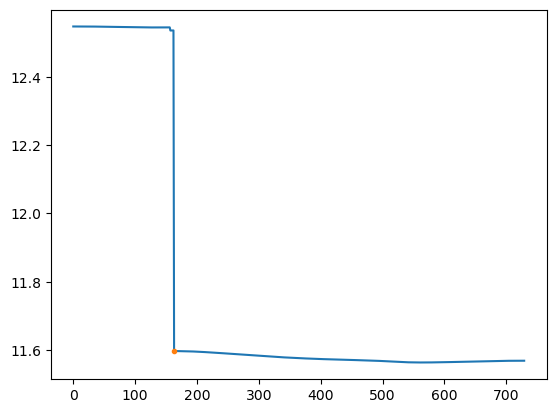

In [23]:
idxs = ~np.isclose(np.diff(qosd_s1), 0, atol=1e-2)

plt.plot(qosd_s1)
plt.plot(np.arange(1,730,1)[idxs], qosd_s1[1:][idxs], marker=".", linewidth=0)

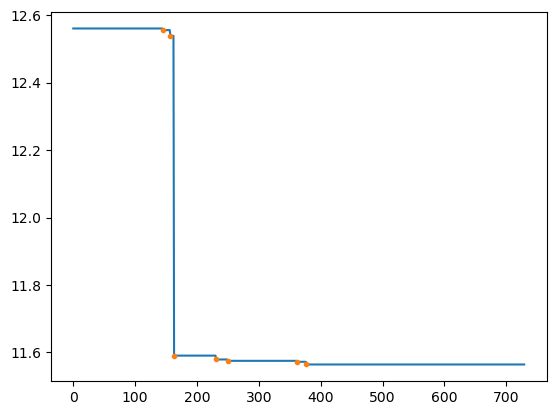

In [49]:
idxs = ~np.isclose(np.diff(cvx_s1), 0, atol=1e-4)

plt.plot(cvx_s1)
plt.plot(np.arange(1,730,1)[idxs], cvx_s1[1:][idxs], marker=".", linewidth=0)

## increasing tolerance to 1e-2 with original c1 optimization range

count_jumps  40


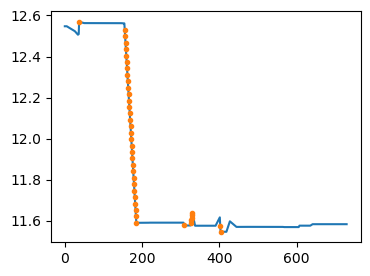

count_jumps  33


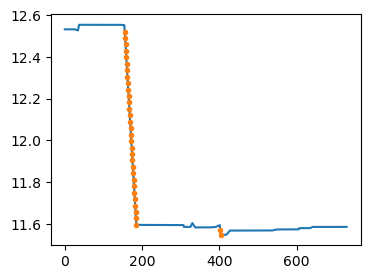

count_jumps  33


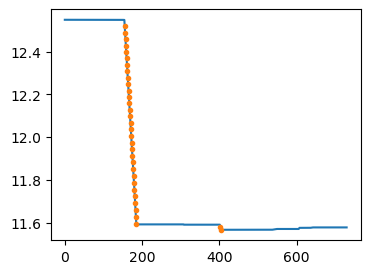

count_jumps  31


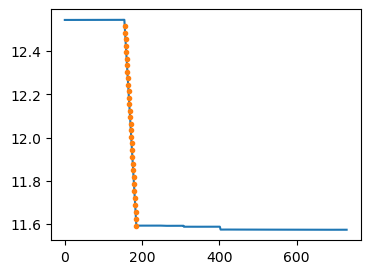

count_jumps  32


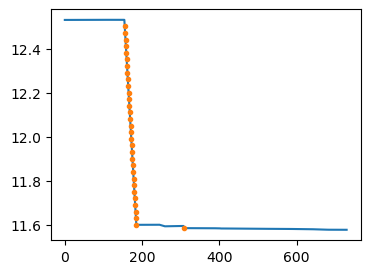

count_jumps  32


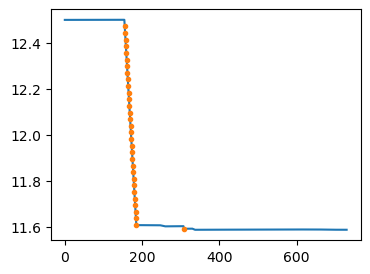

count_jumps  32


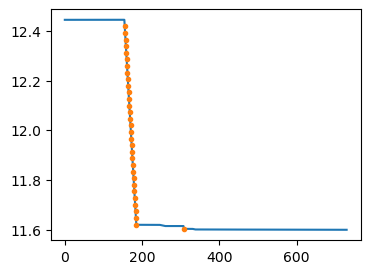

count_jumps  32


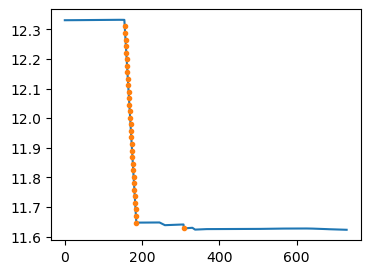

count_jumps  32


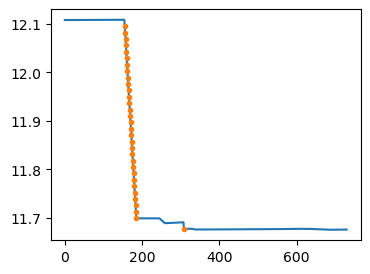

count_jumps  0


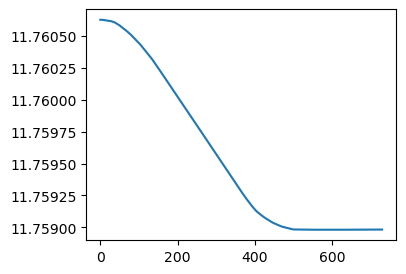

count_jumps  0


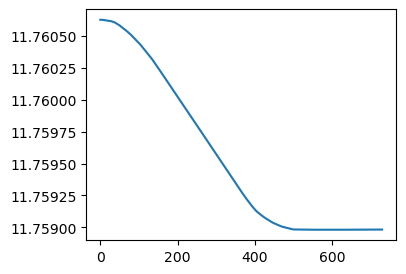

ValueError: zero-size array to reduction operation fmax which has no identity

In [35]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSD()
qosd_time_shift_analysis.atol = 1e-2
qosd_time_shift_analysis.plot_jumps = True

qosd_time_shift_analysis.run(power_data_matrix, c2=200, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1
qosd_s2 = qosd_time_shift_analysis.s2

##### CVX
cvx_time_shift_analysis = TimeShiftCVX()
cvx_time_shift_analysis.atol = 1e-4
cvx_time_shift_analysis.run(power_data_matrix, c2=200, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1
cvx_s2 = cvx_time_shift_analysis.s2

#osd_time_shift_analysis.plot_analysis()
#qosd_time_shift_analysis.plot_optimization()

print(f's1 MAE (OSD,CVX)   {mae(qosd_s1, cvx_s1):.2e}')
print(f's2 MAE (OSD,CVX)   {mae(qosd_s2, cvx_s2):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(qosd_s1, label="OSD")
ax1.plot(cvx_s1, label="CVXPY")
ax2.plot(qosd_s2)
ax2.plot(cvx_s2)
ax1.legend()
plt.show()

## SumCard for iterative reweighting?

/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_40549/3822311341.py:103: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


CVX c1s  [  0.1          0.19952623   0.39810717   0.79432823   1.58489319
   3.16227766   6.30957344  12.58925412  25.11886432  50.11872336
 100.        ]
CVX best c1  6.30957344480193
c1  6.30957344480193


/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_40549/2658331527.py:101: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


s1 MAE (OSD,CVX)   3.67e-01
s2 MAE (OSD,CVX)   2.94e-01


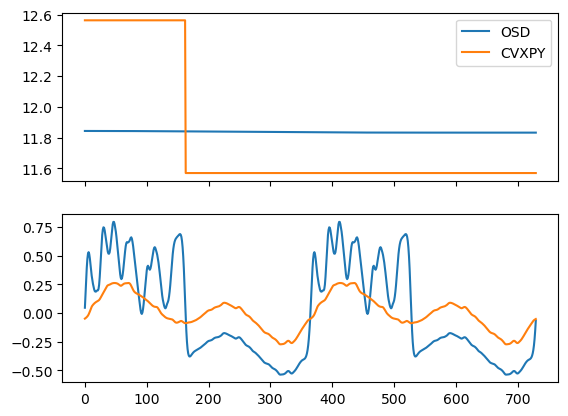

In [12]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSD()
qosd_time_shift_analysis.atol = 1e-2
qosd_time_shift_analysis.sum_card_bool = True
qosd_time_shift_analysis.run(power_data_matrix, c1=5, c2=200, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1
qosd_s2 = qosd_time_shift_analysis.s2

##### CVX
cvx_time_shift_analysis = TimeShiftCVX()
cvx_time_shift_analysis.atol = 1e-2
cvx_time_shift_analysis.iterative_reweight = True

cvx_time_shift_analysis.run(power_data_matrix, c2=200, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1
cvx_s2 = cvx_time_shift_analysis.s2

# cvx_time_shift_analysis.plot_analysis()
# cvx_time_shift_analysis.plot_optimization()

print(f's1 MAE (OSD,CVX)   {mae(qosd_s1, cvx_s1):.2e}')
print(f's2 MAE (OSD,CVX)   {mae(qosd_s2, cvx_s2):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(qosd_s1, label="OSD")
ax1.plot(cvx_s1, label="CVXPY")
ax2.plot(qosd_s2)
ax2.plot(cvx_s2)
ax1.legend()
plt.show()

/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_70896/3960077153.py:104: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


c1  200


/var/folders/zz/zvb8y0jx2sb5q3hn972ys2d5zzzdd3/T/ipykernel_70896/2658331527.py:101: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  (mode(np.round(s1, 3)).mode[0] - s1) * data.shape[0] / 24, 0


s1 MAE (OSD,CVX)   3.65e-01
s2 MAE (OSD,CVX)   2.93e-01


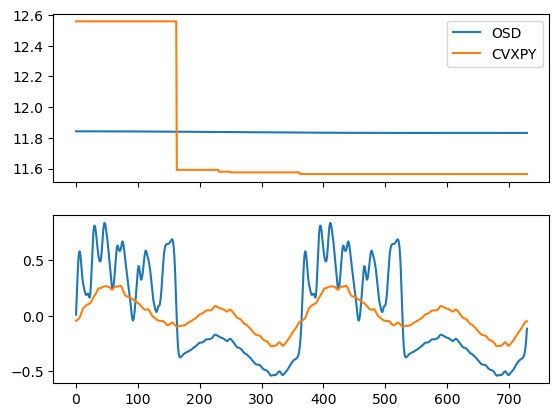

In [56]:
##### OSD
qosd_time_shift_analysis = TimeShiftOSD()
qosd_time_shift_analysis.atol = 1e-2
qosd_time_shift_analysis.sum_card_bool = True
qosd_time_shift_analysis.run(power_data_matrix, c1=200, c2=100, use_ixs=use_days, solver="QSS") 
qosd_actual_power_data_fix = qosd_time_shift_analysis.corrected_data
qosd_s1 = qosd_time_shift_analysis.s1
qosd_s2 = qosd_time_shift_analysis.s2

##### CVX
cvx_time_shift_analysis = TimeShiftCVX()
cvx_time_shift_analysis.atol = 1e-2
cvx_time_shift_analysis.run(power_data_matrix, c1=200, c2=100, use_ixs=use_days, solver="MOSEK")
cvx_actual_power_data_fix = cvx_time_shift_analysis.corrected_data
cvx_s1 = cvx_time_shift_analysis.s1
cvx_s2 = cvx_time_shift_analysis.s2

# cvx_time_shift_analysis.plot_analysis()
# cvx_time_shift_analysis.plot_optimization()

print(f's1 MAE (OSD,CVX)   {mae(qosd_s1, cvx_s1):.2e}')
print(f's2 MAE (OSD,CVX)   {mae(qosd_s2, cvx_s2):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(qosd_s1, label="OSD")
ax1.plot(cvx_s1, label="CVXPY")
ax2.plot(qosd_s2)
ax2.plot(cvx_s2)
ax1.legend()
plt.show()